<a href="https://colab.research.google.com/github/Himanshu069/trictrl/blob/sim/NMPC-Imitation/(BC)NN_controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch pandas scikit-learn
!pip install matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# Load CSV
df = pd.read_csv('nmpc_dataset[omega0andvarying].csv')
# df2 = pd.read_csv('nmpc_dataset[triangle-stabilization].csv')

# df = pd.concat([df1, df2], ignore_index=True)
df = df.sort_values(['time']).reset_index(drop=True)
df['theta_next'] = df['theta'].shift(-1)
df['dtheta_next'] = df['dtheta'].shift(-1)
df['dphi_next'] = df['dphi'].shift(-1)
df['dt'] = df['time'].diff().shift(-1)
df = df.dropna()


X = df[['theta', 'dtheta']].values
# X_next = df[['theta_next', 'dtheta_next', 'dphi_next']].values
dt_array = df['dt'].values
y = df['u'].values.reshape(-1, 1)

# Convert to float32 for PyTorch
X = X.astype(np.float32)
# X_next = X_next.astype(np.float32)
dt_array = dt_array.astype(np.float32)
y = y.astype(np.float32)

# Split: 60% train, 20% validation, 20% test
indices = np.arange(len(X))
train_idx, temp_idx = train_test_split(indices, test_size=0.4, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]
# X_train, X_next_train, dt_train, y_train = X[train_idx], X_next[train_idx], dt_array[train_idx], y[train_idx]
# X_val, X_next_val, dt_val, y_val = X[val_idx], X_next[val_idx], dt_array[val_idx], y[val_idx]
# X_test, X_next_test, dt_test, y_test = X[test_idx], X_next[test_idx], dt_array[test_idx], y[test_idx]

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
std[std == 0] = 1e-8

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# X_train = np.vstack([
#     X_train,
#     X_train * np.array([-1, -1, -1], dtype=np.float32)  # ensure float32
# ]).astype(np.float32)

# y_train = np.vstack([
#     y_train,
#     -y_train
# ]).astype(np.float32)
# X_next_train = (X_next_train - mean) / std
# X_next_val = (X_next_val - mean) / std
# X_next_test = (X_next_test - mean) / std

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
# train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(X_next_train), torch.from_numpy(dt_train), torch.from_numpy(y_train))
# val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(X_next_val), torch.from_numpy(dt_val), torch.from_numpy(y_val))
# test_dataset = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(X_next_test), torch.from_numpy(dt_test), torch.from_numpy(y_test))

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class NMPCNet(nn.Module):
    def __init__(self, input_dim=2, hidden1=64, hidden2=64, output_dim=1):
        super(NMPCNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Initialize network
model = NMPCNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# M = 0.01825
# mb = 0.286
# mw = 0.079
# Iw = 0.000040394
# Ib = 0.0004370975
# lb = 0.05
# lw = 0.05
# g = 9.81
# I = Ib + mb*lb*lb + mw*lw*lw
# def dynamics_continuous(X_norm, u):
#     """
#     Continuous-time dynamics: dX/dt = f(X, u)
#     X_norm: normalized [theta, dtheta, dphi]
#     u: control torque
#     Returns: normalized derivatives [dtheta, ddtheta, ddphi]
#     """
#     # Denormalize
#     X = X_norm * torch.tensor(std, dtype=torch.float32) + torch.tensor(mean, dtype=torch.float32)

#     theta = X[:, 0]
#     dtheta = X[:, 1]
#     dphi = X[:, 2]

#     # Equations of motion
#     ddtheta = (M*g*torch.sin(theta) - u.squeeze()) / I
#     ddphi = u.squeeze()/Iw - ddtheta

#     # Stack derivatives
#     X_dot = torch.stack([dtheta, ddtheta, ddphi], dim=1)

#     # Normalize
#     X_dot_norm = X_dot / torch.tensor(std, dtype=torch.float32)
#     return X_dot_norm

# def rk4_step(X_norm, u, dt):
#     """RK4 integration"""
#     k1 = dynamics_continuous(X_norm, u)
#     k2 = dynamics_continuous(X_norm + dt/2 * k1, u)
#     k3 = dynamics_continuous(X_norm + dt/2 * k2, u)
#     k4 = dynamics_continuous(X_norm + dt * k3, u)

#     X_next_norm = X_norm + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
#     return X_next_norm

In [ ]:

# lambda_physics = 0.01
# lambda_theta = 0.1
# theta_thresh = 0.35
# Early stopping parameters
max_epochs = 1000          # Maximum epochs, safety limit
patience = 40              # Stop if no improvement in 'patience' epochs
min_delta = 1e-6           # Minimum change to qualify as improvement

best_val_loss = float('inf')
epochs_no_improve = 0
train_losses, val_losses = [], []

for epoch in range(max_epochs):
    # --- Training ---
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        u_pred = model(X_batch)
        loss_supervised = criterion(u_pred, y_batch)

        # X_next_pred = torch.zeros_like(X_next_batch)

        # for i in range(len(X_batch)):
        #     X_next_pred[i] = rk4_step(X_batch[i:i+1], u_pred[i:i+1], dt_batch[i].item())

        # theta_next = X_next_pred[:, 0] * std[0] + mean[0]
        # mask = (theta_next.abs() < theta_thresh).float()
        # loss_theta = lambda_theta * torch.mean(mask * theta_next**2)

        # loss_physics = criterion(X_next_pred, X_next_batch)

        # Total loss
        loss = loss_supervised
        # + lambda_physics * loss_physics + loss_theta

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            u_pred = model(X_batch)
            loss_supervised = criterion(u_pred, y_batch)

            # X_next_pred = torch.zeros_like(X_next_batch)
            # for i in range(len(X_batch)):
            #     X_next_pred[i] = rk4_step(X_batch[i:i+1], u_pred[i:i+1], dt_batch[i].item())

            # theta_next = X_next_pred[:, 0] * std[0] + mean[0]
            # mask = (theta_next.abs() < theta_thresh).float()
            # loss_theta = lambda_theta * torch.mean(mask * theta_next**2)

            # loss_physics = criterion(X_next_pred, X_next_batch)

            loss = loss_supervised
            # + lambda_physics * loss_physics + loss_theta
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch+1}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        epochs_no_improve = 0
                # Save checkpoint when improvement occurs
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'train_loss': train_loss
        }
        torch.save(checkpoint, 'best_model_checkpoint.pth')
        print("Validation loss improved — checkpoint saved.")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
        break

Epoch [1], Train Loss: 0.001979, Val Loss: 0.001343
Validation loss improved — checkpoint saved.
Epoch [2], Train Loss: 0.000893, Val Loss: 0.000746
Validation loss improved — checkpoint saved.
Epoch [3], Train Loss: 0.000729, Val Loss: 0.000558
Validation loss improved — checkpoint saved.
Epoch [4], Train Loss: 0.000432, Val Loss: 0.000477
Validation loss improved — checkpoint saved.
Epoch [5], Train Loss: 0.000389, Val Loss: 0.000412
Validation loss improved — checkpoint saved.
Epoch [6], Train Loss: 0.000372, Val Loss: 0.000384
Validation loss improved — checkpoint saved.
Epoch [7], Train Loss: 0.000293, Val Loss: 0.000373
Validation loss improved — checkpoint saved.
Epoch [8], Train Loss: 0.000307, Val Loss: 0.000479
Epoch [9], Train Loss: 0.000256, Val Loss: 0.000430
Epoch [10], Train Loss: 0.000257, Val Loss: 0.000250
Validation loss improved — checkpoint saved.
Epoch [11], Train Loss: 0.000242, Val Loss: 0.000529
Epoch [12], Train Loss: 0.000217, Val Loss: 0.000212
Validation lo

Test Loss: 0.000087

===== PERFORMANCE SUMMARY =====
Training Loss (Final): 0.000056
Validation Loss (Best): 0.000032
Test Loss (MSE): 0.000087
Test RMSE: 0.009302
Test MAE: 0.003511
Test R² Score: 0.993357
Correlation between predicted and true control: 0.9969
Model saved to nmpc_nn_controller.pth


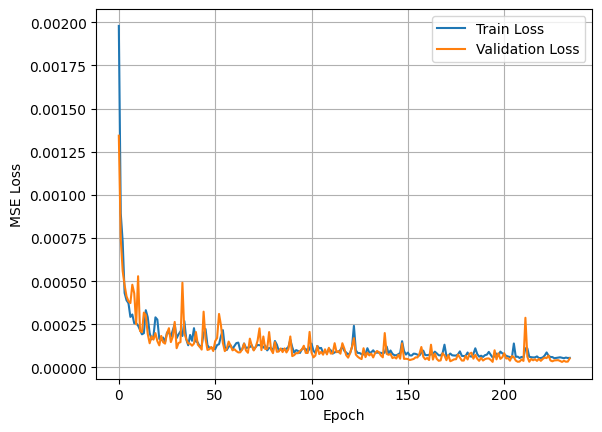

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model.eval()
y_true_all, y_pred_all = [], []
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        u_pred = model(X_batch)
        loss_supervised = criterion(u_pred, y_batch)

        # X_next_pred = torch.zeros_like(X_next_batch)
        # for i in range(len(X_batch)):
        #     X_next_pred[i] = rk4_step(X_batch[i:i+1], u_pred[i:i+1], dt_batch[i].item())

        # theta_next = X_next_pred[:, 0] * std[0] + mean[0]
        # mask = (theta_next.abs() < theta_thresh).float()
        # loss_theta = lambda_theta * torch.mean(mask * theta_next**2)

        # loss_physics = criterion(X_next_pred, X_next_batch)
        y_true_all.append(y_batch.numpy())
        y_pred_all.append(u_pred.numpy())
        loss = loss_supervised
        # + lambda_physics * loss_physics + loss_theta
        test_loss += loss.item() * X_batch.size(0)
test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}')
y_true_all = np.vstack(y_true_all)
y_pred_all = np.vstack(y_pred_all)

mse = mean_squared_error(y_true_all, y_pred_all)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_all, y_pred_all)
r2 = r2_score(y_true_all, y_pred_all)

print("\n===== PERFORMANCE SUMMARY =====")
print(f"Training Loss (Final): {train_losses[-1]:.6f}")
print(f"Validation Loss (Best): {best_val_loss:.6f}")
print(f"Test Loss (MSE): {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test R² Score: {r2:.6f}")

# Optional correlation
corr = np.corrcoef(y_true_all.squeeze(), y_pred_all.squeeze())[0, 1]
print(f"Correlation between predicted and true control: {corr:.4f}")

model_path = 'nmpc_nn_controller.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_loss': best_val_loss,
    'mean': mean,
    'std': std,
}, model_path)

print(f"Model saved to {model_path}")
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import numpy as np
from torch import nn

# --- Load checkpoint ---
checkpoint = torch.load('nmpc_nn_controller.pth', map_location='cpu',weights_only=False)
state_dict = checkpoint['model_state_dict']

# --- Load weights into model ---
model = NMPCNet()
model.load_state_dict(state_dict)
model.eval()
# --- Extract parameters into NumPy ---
weights = {name: param.detach().numpy() for name, param in model.named_parameters()}
weights['mean'] = mean.astype(np.float32)
weights['std'] = std.astype(np.float32)

# --- Save them as .npz ---
np.savez("nmpc_nn_controller(tv-1%).npz", **weights)
print("Converted to NumPy file: nmpc_nn_controller-BC.npz")

Converted to NumPy file: nmpc_nn_controller-BC.npz
